In [1]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline


## Implementation of the stability criterion from Laskar 2017, http://adsabs.harvard.edu/abs/2017A&amp;A...605A..72L


$\beta$ for planet $i$ is defined as,

$\beta_i = 2 \frac{C}{\Lambda_i C_c} $ 

where, 

$ \frac{C}{\Lambda_i} = \sum_{k=1}^n \frac{m_k}{m_i} \left(\frac{P_k}{P_i} \right)^{1/3} \left[1 - \sqrt{1 - e_k^2}\right]$

and $C_c$ is found by the following procedure: 

1) If the planet is the innermost planet then $C_c = 1$

1) If the planet is not the innermost planet, then given $\alpha = (P_{i}/P_{i-1})^{2/3}$ and $\gamma = m_{i}/m_{i-1}$ find the value for $e_c$ such that,

$ F(e_c,\alpha,\gamma) = \alpha e + \frac{\gamma e}{\sqrt{\alpha (1 -e^2) + (\gamma e)^2}} -1 + \alpha = 0$

2) Given $e_c$, $e_c'$ is found via $e_c' = 1 - \alpha - \alpha e_c$

3) Given $e_c$ and $e_c'$ compute the AMD for planet pair with $e_{i-1}=e_c$ and $e_{i} = e_c'$,

$C_c = \gamma \sqrt{\alpha} (1 - \sqrt{1 - e_c^2}) + (1 - \sqrt{1 - e_c'^2}) $

In [36]:
x,y = 0

TypeError: 'int' object is not iterable

In [235]:
class System():
    def __init__(self,planets,name=''):
        self.planets = []
        self.averages = []
        for planet in planets:
            try:
                p_avg,p_err = planet['p']
                p = np.random.normal(p_avg,p_err)
                if p <= 0:
                    p = 0
            except TypeError:
                p = planet['p']
                p_avg = p
            try:
                m_avg,m_err = planet['m']
                m = np.random.normal(m_avg,m_err)
                if m <= 0:
                    m = 0
            except TypeError:
                m = planet['m']
                m_avg = m
            try:
                e_avg,e_err = planet['e']
                e = np.random.normal(e_avg,e_err)
                e  = np.sqrt(e**2 + (e-e_avg)**2)
                if e > 1:
                    e = 1.
            except TypeError:
                e = planet['e']
                e_avg = e
            self.planets.append({'p':p,'e':e,'m':m})
            self.averages.append({'p':p_avg,'e':e_avg,'m':m_avg})
                
        self.nplanets = len(planets)
        self.name = name
    
        
    def amd(self,i):
        """C/Lam_i for planet i"""

        res = 0
        pi = self.planets[i]['p']
        mi = self.planets[i]['m']
        ei = self.planets[i]['e']
        pavg = self.averages[i]['p']
        mavg = self.averages[i]['m']
        for planet in self.planets:
            period = planet['p']
            mass = planet['m']
            e = planet['e']
            alpha = (period/pavg*(1 - (pi-pavg)/pavg))**(2./3)
            gamma = mass/mavg *(1 - (mi-mavg)/mavg)
            res += gamma * np.sqrt(alpha) *(1 - np.sqrt(1 - e*e))
        return res
    
    def beta_values(self):
        """Get the beta values for the system"""

        res = [self.get_beta(i) for i in range(self.nplanets)]
        return np.array(res)
    def get_beta(self,i):
        """Get the beta value for the pair i-1 and i"""
        eta = self.amd(i)
        Cc = self.critical_C(i)
        return 2*eta/Cc
    def critical_C(self,i):
        """Get C_crit for the pair i-1 and i"""
        if i == 0:
            # Inner planet returns C_crit = 1
            return 1.
        planet_1 = self.planets[i-1]
        planet_2 = self.planets[i]
        p1,e1,m1 = [planet_1[i] for i in ['p','e','m']]
        p2,e2,m2 = [planet_2[i] for i in ['p','e','m']]
        p2_avg = self.averages[i]['p']
        m2_avg = self.averages[i]['m']
        
        alpha = (p1/p2_avg*(1 - (p2 - p2_avg)/p2_avg))**(2./3)
        gamma = (m1/m2_avg *(1 - (m2-m2_avg)/m2_avg))
        if np.isinf(gamma):
            return 1 - np.sqrt(alpha*(2-alpha))
        if gamma > 1e5:
            return 1 - np.sqrt(alpha*(2-alpha)) - np.sqrt(alpha)*(1-alpha)**2/(2-alpha) * 1./gamma
        if gamma < 1e-5:
            if alpha == .5:
                return gamma/np.sqrt(2)
            if alpha < .5:
                return 1 - 2*np.sqrt(alpha*(1-alpha)) + gamma*np.sqrt(alpha)
            return gamma*(np.sqrt(alpha)  - np.sqrt(2 - 1./alpha))
        
        ec_in = self.get_ec(alpha,gamma)
        ec_out = 1 - alpha - alpha*ec_in
        return gamma*np.sqrt(alpha)*(1 - np.sqrt(1-ec_in*ec_in)) + (1-np.sqrt(1-ec_out*ec_out))
        
    def func(self,e,a,g):
        if e >= 1:
            return 2*a
        if e <=0:
            return -1+a
        return a*e + g*e/np.sqrt(a*(1-e*e) + (g*e)**2) - 1 + a
    def func_jac(self,e,a,g):
        return a + g*a*(a*(1-e*e) + (g*e)**3)**(-1.5) 
    def get_ec(self,a,g):
        """Find the critical eccentricty."""
        from scipy.optimize import fsolve
        e0 = np.linspace(0,1,100)
        guess = e0[:-1][np.diff(np.sign(np.array([self.func(i,a,g) for i in e0])))==2][0]
        guess = np.log(1-guess)
        sol = fsolve(lambda x: self.func(1-np.exp(x),a,g),guess,fprime=lambda x: self.func_jac(1-np.exp(x),a,g))
        return 1-np.exp(sol[0])
            
    def plot_system(self,zeropoint=1,fig=None,ax=None,clrbar=False):
        def _clrbar(ax,norm,cmap):
            import matplotlib
            import matplotlib.cm
            import matplotlib.colors as colors
            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('top',size='3%',pad=.05)
            cmap = matplotlib.cm.get_cmap(cmap)
            cb = matplotlib.colorbar.ColorbarBase(ax=cax,cmap=cmap,norm=norm,orientation='horizontal')
            cb.ax.xaxis.set_ticks_position('top')
            cb.ax.xaxis.set_label_position('top')

        import matplotlib.colors as colors
        norm = colors.LogNorm(vmin=1e-2,vmax=1e2)
        if ax is None:
            fig,ax=plt.subplots(figsize=(8,3))
            ax.set_ylim(0,2)
            ax.set_xscale('log')
            ax.set_xlim(1e-3,1e5)
            ax.set_xlabel('Period [days]')
            ax.minorticks_on()
            ax.set_yticklabels('')
        
        if clrbar:
            _clrbar(ax,norm,'coolwarm')
        ax.axhline(zeropoint,c='k',ls=':',zorder=0)
        print('For ', self.name, ':')
        for i,planet in enumerate(self.planets):
            beta = self.get_beta(i)
            mass = planet['m']
            period = planet['p']
            size = 100*np.log10(mass * 1e-3/(3e-6) / (.1))
            print('planet',i,'beta',beta)
            ax.scatter(period,zeropoint,s=size,c=beta,cmap='coolwarm',norm=norm)
        
        
        return fig,ax

        
   

def plot_systems(system_list):
    try:
        n = len(system_list)
    except:
        n = 1
        system_list = [system_list]
    fig,ax=plt.subplots(figsize=(8,3*n))
    yticks = [10*(i+1) for i in range(n)]
    for i,sys in enumerate(system_list):
        ax.axhline(yticks[i],ls=':',c='k',zorder=0)
        sys.plot_system(fig=fig,ax=ax,zeropoint=yticks[i],clrbar=i==0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['{}'.format(sys.name) for sys in system_list])
    
    ax.set_ylim(0,10*(n+1))
    ax.set_xscale('log')
    ax.set_xlim(1e-2,1e5)
    ax.set_xlabel('Period [days]')
    ax.minorticks_on()
    fig.tight_layout()
    return fig,ax



        
        


       

For  HD13808 :
planet 0 beta 0.36491700193827936
planet 1 beta 1.4967279914424927
For  55 Cnc :
planet 0 beta 2.3231560132994384
planet 1 beta 0.08478864716776477
planet 2 beta 0.6632681338642799
planet 3 beta 0.2594586650432933
planet 4 beta 0.0027497396327478903
For  HD 40307 :
planet 0 beta 0.6813863470463885
planet 1 beta 6.214557240023851
planet 2 beta 3.6777301089352283
planet 3 beta 10.296206865034147
planet 4 beta 19.473760416513485
planet 5 beta 0.8405508753449978


(<matplotlib.figure.Figure at 0x112b604e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112b60470>)

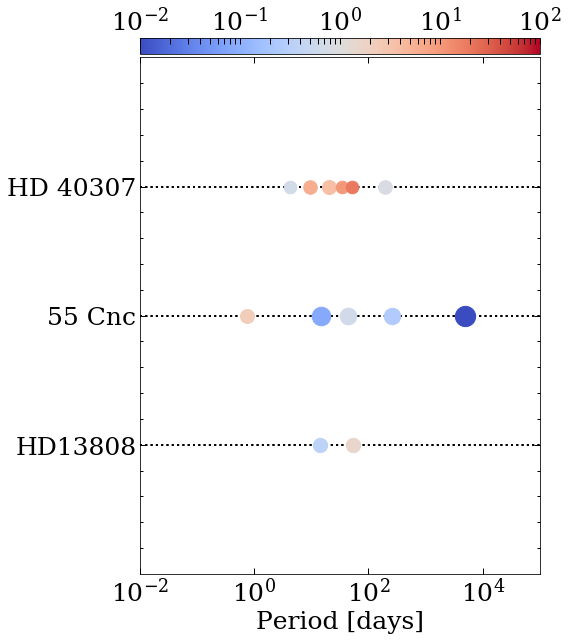

In [236]:
hd13808 = [{'p':14.182, 'e':.17, 'm':.0325},{'p':53.832,'e':.43,'m':.036}]

cnc55 = [{'p':0.7365478, 'e':.028, 'm':.02703},
        {'p':14.65314,'e':.0023,'m':.84},
        {'p':44.373,'e':.072,'m':.1784},
         {'p':260.91,'e':.08,'m':.1479},
        {'p':4867.0,'e':.0269,'m':3.86}]

hd40307 = [{'p':4.3115, 'e':0.2, 'm':.012},
        {'p':9.6207,'e':0.06,'m':.0202},
        {'p':20.4184,'e':0.07,'m':.0275},
         {'p':34.62,'e':0.15,'m':.011},
        {'p':51.56,'e':0.02,'m':.0114},
        {'p':197.8,'e':0.29,'m':.0223}]

systems= [ System(hd13808,name='HD13808'),
          System(cnc55,name='55 Cnc'),
          System(hd40307,name='HD 40307')]



plot_systems(systems)

## Including uncertainties


In [237]:
def plot_system_with_errors(system_list,nsamples=1000,cmap='coolwarm'):
    import matplotlib.colors as colors
    def _clrbar(ax,norm,cmap):
        import matplotlib
        import matplotlib.cm
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('top',size='3%',pad=.05)
        cmap = matplotlib.cm.get_cmap(cmap)
        cb = matplotlib.colorbar.ColorbarBase(ax=cax,cmap=cmap,norm=norm,orientation='horizontal')
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

    try:
        n = len(system_list)
    except:
        n = 1
        system_list = [system_list]
    fig,ax=plt.subplots(figsize=(8,3*n))
    yticks = [10*(i+1) for i in range(n)]
    
    norm = colors.LogNorm(vmin=1e-2,vmax=1e2)
    _clrbar(ax,norm,cmap)
    
    labels=[]
    for i,(name,label) in enumerate(system_list):
        sys = System(name)
        
        betas = np.array([System(name).beta_values() for _ in range(nsamples)])

        
        labels.append('{}'.format(label))
        ax.axhline(yticks[i],ls=':',c='k',zorder=0)
        zeropoint = yticks[i]
        print('For ', label, ':')
        for i,planet in enumerate(sys.planets):
            ind = np.isnan(betas[:,i])|np.isinf(betas[:,i])|(betas[:,i]<0)
            beta = betas[~ind,i].mean()
            sigma = betas[~ind,i].std()
            mass = sys.averages[i]['m']
            period = sys.averages[i]['p']
            size = 100*np.log10(mass * 1e-3/(3e-6) / (.1))
            print('planet',i+1,'beta',beta,'pm',sigma)
            ax.scatter(period,zeropoint,s=size,c=beta,cmap='coolwarm',norm=norm)

    if n > 1:
        ax.set_yticks(yticks)
        ax.set_yticklabels(labels)
    else:
        ax.set_yticks([0,10,20])
        ax.set_yticklabels(['',labels[0],''])

    ax.set_ylim(0,10*(n+1))
    ax.set_xscale('log')
    ax.set_xlim(1e-2,1e5)
    ax.set_xlabel('Period [days]')
    ax.minorticks_on()
    fig.tight_layout()  
    return fig,ax
            

In [238]:
def beta_distributions(system,nsamples=1000,bins=50,log=False,**kargs):
    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_xlabel('$\\beta$',fontsize=20)
    ax.set_ylabel('Normed Counts',fontsize=20)
    sys = System(system)

    betas = np.array([System(system).beta_values() for _ in range(nsamples)])
    for j,planets in enumerate(sys.averages):
        ind = np.isnan(betas[:,j])|np.isinf(betas[:,j])|(betas[:,j]<0)
        ax.hist(betas[~ind,j],bins=bins,histtype='step',
                label='Planet {:d}'.format(j+1),lw=3,normed=True,**kargs)
    if log:
        ax.set_xscale('log')
    ax.legend(loc='best')
    fig.tight_layout()
    return fig,ax

For  HD13808 :
planet 1 beta 0.3740055316204859 pm 0.06264256307949478
planet 2 beta 1.5178651818681421 pm 0.12647089158204897
For  55 Cnc :
planet 1 beta 8.95805263837575 pm 10.101152029714786
planet 2 beta 0.3257376305362331 pm 0.37442924082103307
planet 3 beta 2.5553799053087283 pm 2.9153137397113924
planet 4 beta 0.9992976034409843 pm 1.131925765313531
planet 5 beta 0.010501715575988403 pm 0.011734620538939963


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


For  HD 40307 :
planet 1 beta 2.572748302123506 pm 3.262226575752608
planet 2 beta 23.539762888412575 pm 29.874871999969095
planet 3 beta 13.922001393358931 pm 17.690714454241725
planet 4 beta 38.640127864190816 pm 52.79071166922267
planet 5 beta 84.66782887873082 pm 161.81282856889501
planet 6 beta 2.9310670714308804 pm 3.458832273547777


(<matplotlib.figure.Figure at 0x112909828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112909748>)

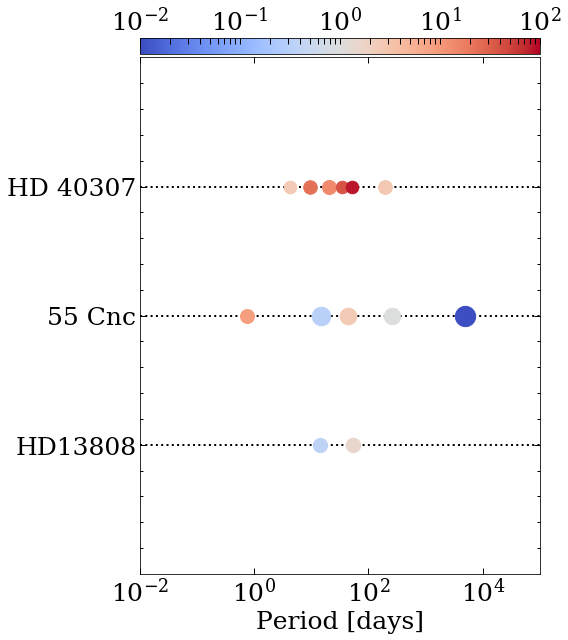

In [239]:
hd13808 = [{ 'p':(14.182,.005) , 'e':(.17,.07), 'm':(.0325,.0029)}
           ,{'p':(53.832,.1127), 'e':(.43,0)  , 'm':(.036,.0051)}]


cnc55 = [{'p':(0.7365478, (1.2e-06 + 1.6e-06)/2), 'e':(.028,(0.019 + .022)/2), 'm':(.02703,.00135)},
         {'p':(14.65314,(.00095+.0009)/2),        'e':(.0023,(.0016+.0025)/2), 'm':(.84,(.031+.23)/2)},
         {'p':(44.373,(.018+.02)/2),              'e':(.072,(.014+.014)/2),    'm':(.1784,(.0078+.0275)/2)},
         {'p':(260.91,.36),                       'e':(.08,(.057+.102)/2),     'm':(.1479,(.0093+.0219)/2)},
         {'p':(4867.0,(25.+26)/2),                'e':(.0269,(.0065+.061)/2),  'm':(3.86,(.15+.6)/2)}]

hd40307 = [{'p':(4.3115,.00027),  'e':(0.2,(.16+.14)/2.), 'm':(.012,.00094)},
           {'p':(9.6207,.0013),   'e':(0.06,(.06+.11)/2), 'm':(.0202,.0014)},
           {'p':(20.4184,.0052),  'e':(0.07,(.07+.11)/2), 'm':(.0275,.0018)},
           {'p':(34.62, .21),     'e':(0.15,(.15+.13)/2), 'm':(.011,.0044)},
           {'p':(51.56,.14),      'e':(0.02,(.02+.2)/2.), 'm':(.0114,.0019)},
           {'p':(197.8,(5.7+9)/2),'e':(0.29,(.29+.31)/2), 'm':(.0223,.0082)}]


systems= [(hd13808,'HD13808'),
          (cnc55,'55 Cnc'),
          (hd40307,'HD 40307')]


plot_system_with_errors(systems,nsamples=10000)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


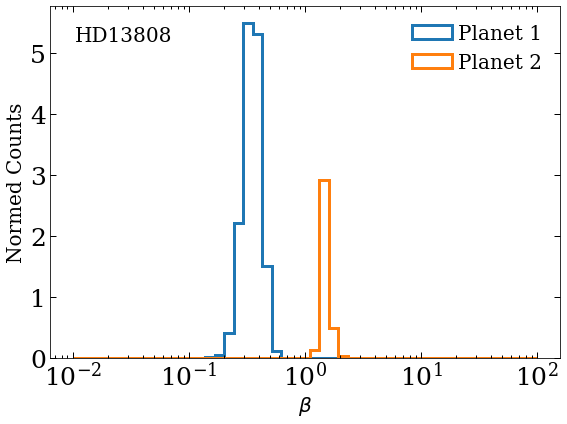

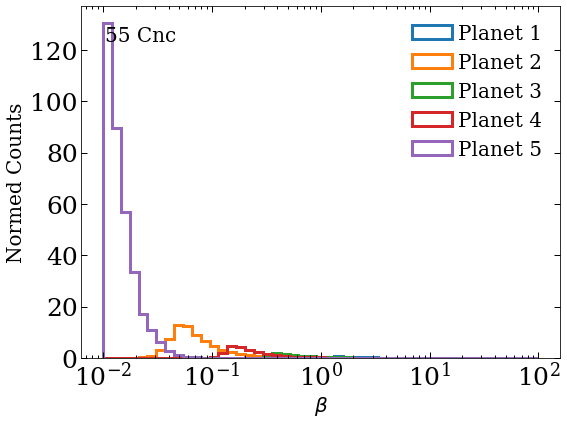

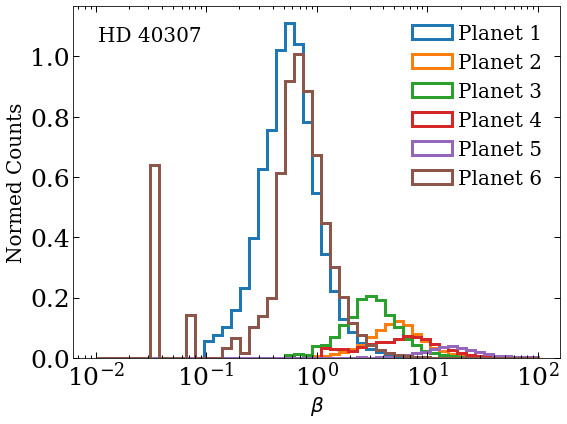

In [240]:
for sys,name in systems:
    fig,ax=beta_distributions(sys,bins=np.logspace(-2,2,50),log=True,nsamples=10000)
    ax.text(.05,.9,name,transform=ax.transAxes,fontsize=20)